In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# packing and unpacking images
def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

# generates a 784 element mask with columns deleted
# from the right side of the image towards the left
# keep = 1, throwaway = 0
def generateColumnMask(delColumns):
    mask = np.ones((28, 28))
    mask[:, (28 - delColumns):] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# generate a 784 element mask with a square, with side
# length (sideLength), zero'd out of the middle
def generateCenterSquareMask(sideLength):
    mask = np.ones((28, 28))
    leftIdx = (28 - sideLength)/2
    rightIdx = (28 + sideLength)/2
    mask[leftIdx:rightIdx, leftIdx:rightIdx] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# zero out indices of a vector for a data matrix
# for a given mask
def hideData(data, mask):
    # copy the data
    newData = data.copy()
    
    # get indices from the mask
    x_idx = np.where([mask==1])[1]
    y_idx = np.where([mask==0])[1]
    
    # apply the mask
    newData[y_idx, :] = 0
    
    return newData, data[x_idx, :], data[y_idx, :]

# get statistics for mmse
def getStatistics(data, vectorMask):
    # get mean and covariance of original data
    mean = np.mean(data, axis=1)
    cov = np.cov(data)
    
    # get indices for X, Y parts of data
    x_idx = np.where([vectorMask == 0])[1]
    y_idx = np.where([vectorMask == 1])[1]
        
    # apply masks
    u_x = mean[x_idx]
    u_y = mean[y_idx]
    cov_x = cov[x_idx]
    cov_x = cov_x[:, x_idx]
    cov_yx = cov[y_idx]
    cov_yx = cov_yx[:, x_idx]
    cov_y = cov[y_idx]
    cov_y = cov_y[:, y_idx]
    
    # return statistics
    return u_x, u_y, cov_x, cov_yx

# let's get our data
def returnHalfData(endBuffer):
    train = np.load('MNISTcwtrain1000.npy')
    #train = np.load('ReducedMNIST_1.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    if (endBuffer):
        train = np.concatenate((train, train[:, 0:50]), axis = 1)
        #test = np.concatenate((test, test[:, 0:50]), axis = 1)

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(14))
    test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(14))

    return train_hideRight, Xtrain_hideRight, Ytrain_hideRight, test_hideRight, Xtest_hideRight, Ytest_hideRight

# let's get the data for halves
def returnSquareData(endBuffer):
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    if (endBuffer):
        train = np.concatenate((train, train[:, 0:50]), axis = 1)
        #test = np.concatenate((test, test[:, 0:50]), axis = 1)

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle = hideData(train, generateCenterSquareMask(5))
    test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle = hideData(test, generateCenterSquareMask(5))

    return train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle, test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle

# let's get our data
def returnData(endBuffer):
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    if (endBuffer):
        train = np.concatenate((train, train[:, 0:50]), axis = 1)

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    return train, test

In [2]:
# Load standard data
train, test = returnData(endBuffer=False)
train_hideRight, Xtrain_hideRight, Ytrain_hideRight, test_hideRight, Xtest_hideRight, Ytest_hideRight = returnHalfData(endBuffer=False)
mean = np.mean(train, axis = 1)
cov = np.cov(train)

# assumes every column is a data point
def hideRightHalf(data):
    # make copies of data
    newData = data.copy()
    hiddenData = data.copy()
    
    # find the zeroing boundary point
    halfIdx = newData.shape[0]/2
    
    # zero out before and after the boundary point
    newData[halfIdx:, :] = 0
    hiddenData[0:halfIdx, :] = 0
    return newData, hiddenData
    
newTrain, hiddenTrain = hideRightHalf(train)
newTest, hiddenTest = hideRightHalf(test)

def Wstar(cov_x, cov_yx):
    if cov_x.any():
        cov_x_inv = np.linalg.pinv(cov_x)
    else:
        cov_x_inv = cov_x
    W = np.dot(cov_yx, cov_x_inv)
    return W

def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
    W = Wstar(cov_x, cov_yx)
    dist = x - u_x.reshape((u_x.shape[0]), 1)
    return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

size = 784
u_x = mean[0:size/2]
u_y = mean[size/2:]
cov_x = cov[0:size/2, 0:size/2]
cov_yx = cov[size/2:, 0:size/2]
Y_hat_right_train = mmseEstimator(newTrain[0:size/2, :], u_x, u_y, cov_x, cov_yx)
Y_hat_right_test = mmseEstimator(newTest[0:size/2, :], u_x, u_y, cov_x, cov_yx)

x_idx = np.where([generateColumnMask(14) == 1])[1]
y_idx = np.where([generateColumnMask(14) == 0])[1]

Y_hat_train = np.zeros((train.shape[0], train.shape[1]))
Y_hat_test = np.zeros((test.shape[0], test.shape[1]))

Y_hat_train[x_idx] = Xtrain_hideRight
Y_hat_train[y_idx] = Y_hat_right_train
Y_hat_test[x_idx] = Xtest_hideRight
Y_hat_test[y_idx] = Y_hat_right_test

----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000
----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000


In [12]:
# ----------------------------
#    Left to Right
# ----------------------------
predicted_train_LtoR_pre = np.load('predictedTrain_LeftToRight.npy')
predicted_test_LtoR_pre = np.load('predictedTest_LeftToRight.npy')

print '----Generated Data Loaded----'
print predicted_train_LtoR_pre.shape
print predicted_test_LtoR_pre.shape

# For right half image generation, complete the image
predicted_train_LtoR = np.zeros((train.shape[0], train.shape[1]))
predicted_test_LtoR = np.zeros((test.shape[0], test.shape[1]))

predicted_train_LtoR[x_idx] = Xtrain_hideRight
predicted_train_LtoR[y_idx] = predicted_train_LtoR_pre
predicted_test_LtoR[x_idx] = Xtest_hideRight
predicted_test_LtoR[y_idx] = predicted_test_LtoR_pre

#-------------------------
#  MSE for right half image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train[y_idx]
temp2 = test[y_idx]

diff_train = temp1 - predicted_train_LtoR_pre
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test_LtoR_pre
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE


----Generated Data Loaded----
(392, 10000)
(392, 1000)
---- Generated Data MSE ----
Train data: 0.019066
Test data: 0.035813


In [19]:
# ----------------------------
#    Left to Original
# ----------------------------
predicted_train_LtoO = np.load('predictedTrain_LeftToOriginal.npy')
predicted_test_LtoO = np.load('predictedTest_LeftToOriginal.npy')

#-------------------------
#  MSE for whole image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train
temp2 = test

diff_train = temp1 - predicted_train_LtoO
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test_LtoO
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

---- Generated Data MSE ----
Train data: 0.018111
Test data: 0.022777


In [25]:
# ----------------------------
#    Blanked to Original
# ----------------------------
predicted_train_BtoO = np.load('predictedTrain_BlankedToOriginal.npy')
predicted_test_BtoO = np.load('predictedTest_BlankedToOriginal.npy')

#-------------------------
#  MSE for whole image
#-------------------------
# calculate the mse of the training and test sets using affine estimator
temp1 = train
temp2 = test

diff_train = temp1 - predicted_train_BtoO
trainMSEs = np.zeros(10000)
for i in range(10000):
    trainMSEs[i] = np.mean(np.multiply(diff_train[:, i], diff_train[:, i]))
trainMSE = np.mean(trainMSEs)

diff_test = temp2 - predicted_test_BtoO
testMSEs = np.zeros(1000)
for i in range(1000):
    testMSEs[i] = np.mean(np.multiply(diff_test[:, i], diff_test[:, i]))
testMSE = np.mean(testMSEs)

print '---- Generated Data MSE ----'
print 'Train data: %f' %trainMSE
print 'Test data: %f' %testMSE

---- Generated Data MSE ----
Train data: 0.018628
Test data: 0.022200


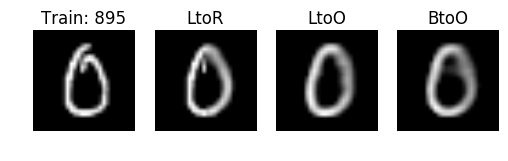

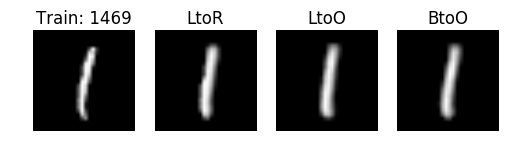

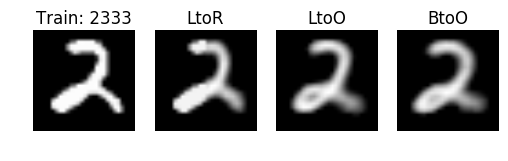

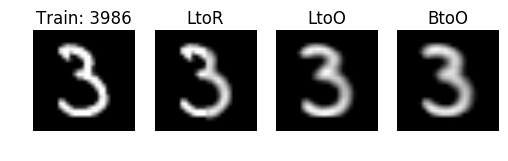

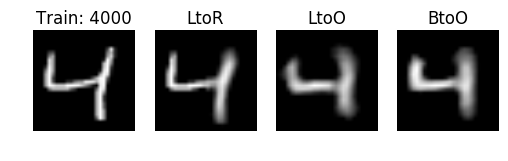

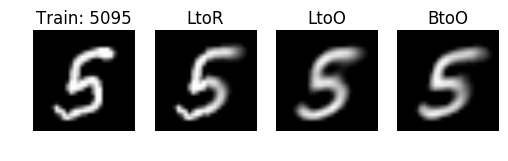

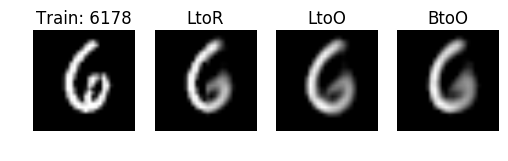

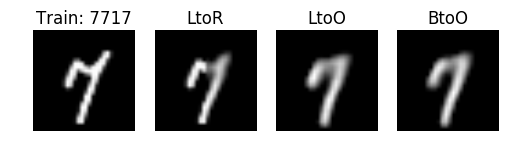

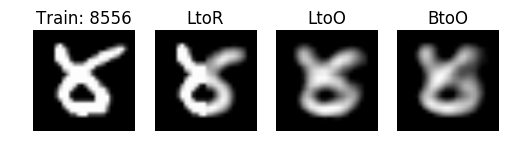

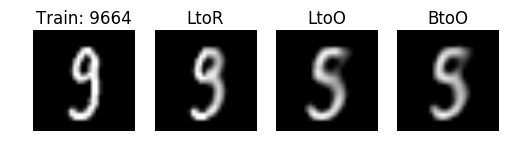

In [32]:
for i in range(10):  
    randomTrain = np.random.randint(i*1000, (i+1)*1000)
    
    origTrain = train[:, randomTrain]
    nn_train_LtoR = predicted_train_LtoR[:, randomTrain]
    nn_train_LtoO = predicted_train_LtoO[:, randomTrain]
    nn_train_BtoO = predicted_train_BtoO[:, randomTrain]

    imgOrigTrain = unpackcw(origTrain, 28, 28)
    imgTrain_LtoR = unpackcw(nn_train_LtoR, 28, 28)
    imgTrain_LtoO = unpackcw(nn_train_LtoO, 28, 28)
    imgTrain_BtoO = unpackcw(nn_train_BtoO, 28, 28)
    
    plt.figure(i);
    plt.subplot(1, 4, 1); plt.imshow(imgOrigTrain, cmap='gray'); plt.title('Train: %d' %randomTrain); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(imgTrain_LtoR, cmap='gray'); plt.title('LtoR'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(imgTrain_LtoO, cmap='gray'); plt.title('LtoO'); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(imgTrain_BtoO, cmap='gray'); plt.title('BtoO'); plt.axis('off')

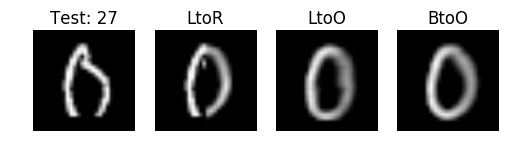

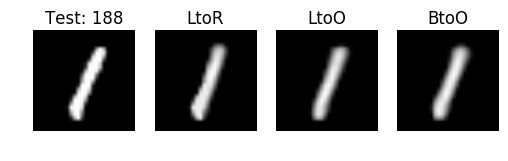

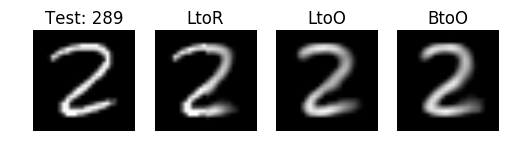

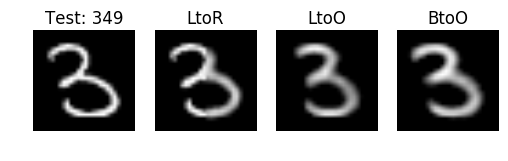

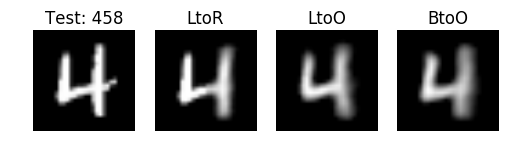

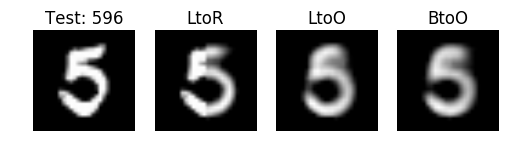

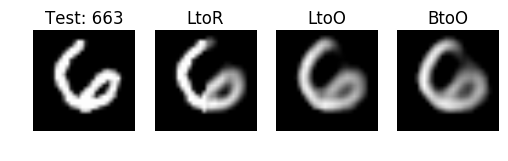

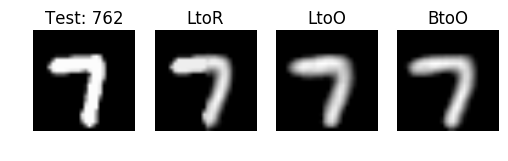

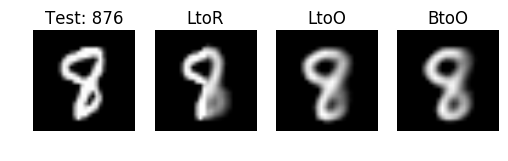

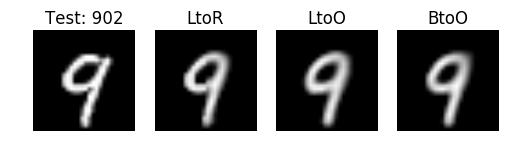

In [33]:
for i in range(10):  
    randomTest = np.random.randint(i*100, (i+1)*100)
    
    origTest = test[:, randomTest]
    nn_test_LtoR = predicted_test_LtoR[:, randomTest]
    nn_test_LtoO = predicted_test_LtoO[:, randomTest]
    nn_test_BtoO = predicted_test_BtoO[:, randomTest]

    imgOrigTest = unpackcw(origTest, 28, 28)
    imgTest_LtoR = unpackcw(nn_test_LtoR, 28, 28)
    imgTest_LtoO = unpackcw(nn_test_LtoO, 28, 28)
    imgTest_BtoO = unpackcw(nn_test_BtoO, 28, 28)

    plt.figure(i); 
    plt.subplot(1, 4, 1); plt.imshow(imgOrigTest, cmap='gray'); plt.title('Test: %d' %randomTest); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(imgTest_LtoR, cmap='gray'); plt.title('LtoR'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(imgTest_LtoO, cmap='gray'); plt.title('LtoO'); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(imgTest_BtoO, cmap='gray'); plt.title('BtoO'); plt.axis('off')